<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks/MNIST_GRAPH_Plot_2_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
print("Loading model...")
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
print("Loading data...")
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')

# Calculate accuracy on clean data
predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")



# Count the occurrences of each label in the test set
unique, counts = np.unique(correct_labels, return_counts=True)
correct_labels_counts = dict(zip(unique, counts))
print("occurrences of each label:", correct_labels_counts)
for label, count in correct_labels_counts.items():
    print(f"Label {label}: {count}")

Loading model...
Loading data...
308/308 [==============================] - 2s 6ms/step
Accuracy on clean data: 99.60%
occurrences of each label: {0: 973, 1: 1133, 2: 1016, 3: 989, 4: 969, 5: 882, 6: 937, 7: 1005, 8: 946, 9: 984}
Label 0: 973
Label 1: 1133
Label 2: 1016
Label 3: 989
Label 4: 969
Label 5: 882
Label 6: 937
Label 7: 1005
Label 8: 946
Label 9: 984


In [8]:
# Assuming you have a dataset `x_test` and labels `y_test`
# Select a subset for demonstration
subset_indices = np.random.choice(range(len(correct_examples)), size=250, replace=False)
subset_images = correct_examples[subset_indices]
subset_labels = correct_labels[subset_indices]

In [9]:
unique, counts = np.unique(subset_labels, return_counts=True)
subset_labels_counts = dict(zip(unique, counts))
print("occurrences of each label:", subset_labels_counts)
for label, count in subset_labels_counts.items():
    print(f"Label {label}: {count}")

occurrences of each label: {0: 25, 1: 26, 2: 17, 3: 32, 4: 29, 5: 23, 6: 21, 7: 17, 8: 34, 9: 26}
Label 0: 25
Label 1: 26
Label 2: 17
Label 3: 32
Label 4: 29
Label 5: 23
Label 6: 21
Label 7: 17
Label 8: 34
Label 9: 26


In [174]:
import numpy as np
import tensorflow as tf

def rotate_image(image, degrees):
    return tf.image.rot90(image, k=degrees // 90)

def adjust_brightness(image, delta):
    return tf.image.adjust_brightness(image, delta)


# def predict_with_confidence(model, images):
#     predictions = model.predict(images)
#     confidence_scores = np.max(predictions, axis=1)  # Max confidence score
#     predicted_classes = np.argmax(predictions, axis=1)  # Predicted class
#     return predictions, confidence_scores, predicted_classes
# def predict_with_confidence(model, images, actual_labels):
#     predictions = model.predict(images)
#     confidence_scores = np.max(predictions, axis=1)  # Max confidence score
#     predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices
#     correct_predictions = predicted_classes == actual_labels  # True/False array for correctness
#     return predictions, confidence_scores, predicted_classes, correct_predictions

def predict_with_confidence(model, images, actual_labels):
    predictions = model.predict(images)
    confidence_scores = np.max(predictions, axis=1)  # Max confidence score per prediction
    predicted_classes = np.argmax(predictions, axis=1)  # Predicted class for each image

    # Ensure actual_labels is a NumPy array and has the same shape as predicted_classes
    actual_labels_array = np.asarray(actual_labels)
    if actual_labels_array.shape != predicted_classes.shape:
        raise ValueError("Shape mismatch between predicted classes and actual labels")

    # Perform element-wise comparison
    correct_predictions = predicted_classes == actual_labels_array

    return predictions, confidence_scores, predicted_classes, correct_predictions


def apply_transformation_and_predict(model, images, actual_labels, transformation_func, **kwargs):
    # Apply the appropriate transformation to each image based on the given function and kwargs
    if transformation_func == rotate_image:
        transformed_images = np.array([transformation_func(image, kwargs['degrees']) for image in images])
    elif transformation_func == adjust_brightness:
        transformed_images = np.array([transformation_func(image, kwargs['delta']) for image in images])
    else:
        raise ValueError("Unknown transformation function.")

    # Ensure actual_labels is correctly aligned with the transformed images
    # Note: This assumes actual_labels is already correctly ordered and matches images one-to-one

    # Call predict_with_confidence, now passing the actual_labels that correspond to the transformed images
    return predict_with_confidence(model, transformed_images, actual_labels)


properties = {
    'rotation': [90],  # Degrees
    'brightness': [0.4]  # Delta
}
import numpy as np
import tensorflow as tf
import csv

# Assuming subset_images, subset_labels, and model are already defined
# Ensure subset_labels is a NumPy array for compatibility
subset_labels = np.array(subset_labels)

def filter_images_by_class(images, labels, target_class):
    """Filter images and labels to include only those belonging to the target class."""
    filtered_images = images[labels == target_class]
    return filtered_images, labels[labels == target_class]

# Initialize results storage
results = {}

# Iterate over each property and its transformation values
for property_name, values in properties.items():
    for value in values:
        for class_label in np.unique(subset_labels):
            class_images, class_labels = filter_images_by_class(subset_images, subset_labels, class_label)
            # Apply the appropriate transformation and predict
            if property_name == 'rotation':
                _, confidence_scores, predicted_classes, correct_predictions = apply_transformation_and_predict(
                    model, class_images, class_labels, rotate_image, degrees=value)
            elif property_name == 'brightness':
                _, confidence_scores, predicted_classes, correct_predictions = apply_transformation_and_predict(
                    model, class_images, class_labels, adjust_brightness, delta=value)

            # Construct a unique key for each combination of property, value, and class
            results_key = f"{property_name}_{value}_class_{class_label}"
            results[results_key] = {
                'confidence_scores': confidence_scores.tolist(),
                'predicted_classes': predicted_classes.tolist(),
                'correct_predictions': correct_predictions.tolist()
            }

# Save results to CSV
filename = "confidence_scores.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Property', 'Value', 'Class Label', 'Sample Index', 'Confidence Score', 'Predicted Class', 'Correctness'])

    for key, data in results.items():
        property_name, value, _, class_label = key.split('_')
        for i in range(len(data['confidence_scores'])):
            writer.writerow([
                property_name,
                value,
                class_label,
                i,
                data['confidence_scores'][i],
                data['predicted_classes'][i],
                "Correct" if data['correct_predictions'][i] else "Incorrect"
            ])


1/1 [==============================] - 0s 24ms/step


In [182]:
# Load the confidence scores from the CSV file into a pandas DataFrame
import pandas as pd

df = pd.read_csv("confidence_scores.csv")

# Calculate accuracy for each property
accuracy_by_property = {}
for property_name in properties.keys():
    property_df = df[df['Property'] == property_name]
    total_samples = len(property_df)
    correct_predictions = property_df[property_df['Correctness'] == 'Correct']['Correctness'].count()
    accuracy = correct_predictions / total_samples
    accuracy_by_property[property_name] = accuracy

# Print accuracy for each property
for property_name, accuracy in accuracy_by_property.items():
    print(f"Accuracy for {property_name}: {accuracy * 100:.2f}%")


Accuracy for rotation: 10.80%
Accuracy for brightness: 86.00%


In [183]:
# Print accuracy for each property
for property_name, accuracy in accuracy_by_property.items():
    print(f"Accuracy for {property_name}: {accuracy:.4f}")

Accuracy for rotation: 0.1080
Accuracy for brightness: 0.8600


In [184]:
import pandas as pd

# Initialize dictionaries to hold the aggregated data
data = {'Property': [], 'Class': [], 'Confidence Score': []}

# Iterate over each property and its transformation values
for property_name, values in properties.items():
    for value in values:
        for class_label in np.unique(subset_labels):
            # Construct the results key for each combination of property, value, and class
            results_key = f"{property_name}_{value}_class_{class_label}"
            # Calculate the mean confidence score for the current property, value, and class
            mean_confidence_score = np.mean(results[results_key]['confidence_scores'])
            # Append the property, class, and mean confidence score to the data dictionary
            data['Property'].append(property_name)
            data['Class'].append(class_label)
            data['Confidence Score'].append(mean_confidence_score)

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to create a table with properties as columns and classes as rows
pivot_table = df.pivot(index='Class', columns='Property', values='Confidence Score')

# Display the table
print(pivot_table)


Property  brightness  rotation
Class                         
0           0.999409  0.884213
1           0.816283  0.824897
2           0.937802  0.835891
3           0.964609  0.866728
4           0.910466  0.857488
5           0.860783  0.936549
6           0.999477  0.910892
7           0.849851  0.898909
8           0.999114  0.820688
9           0.960652  0.903338


In [185]:
# Calculate the product of mean confidence scores across properties for each class
pivot_table['Confidence Product'] = pivot_table.prod(axis=1)

# Display the updated table
print(pivot_table)


Property  brightness  rotation  Confidence Product
Class                                             
0           0.999409  0.884213            0.883691
1           0.816283  0.824897            0.673350
2           0.937802  0.835891            0.783901
3           0.964609  0.866728            0.836053
4           0.910466  0.857488            0.780714
5           0.860783  0.936549            0.806166
6           0.999477  0.910892            0.910416
7           0.849851  0.898909            0.763939
8           0.999114  0.820688            0.819961
9           0.960652  0.903338            0.867793


In [186]:
# Step 1: Calculate the mean confidence score for each property individually
mean_confidence_rotation = pivot_table['rotation'].mean()
mean_confidence_brightness = pivot_table['brightness'].mean()

# Step 2: Calculate the product of the mean confidence scores of two properties
product_of_means = mean_confidence_rotation * mean_confidence_brightness

# Step 3: Add the calculated mean confidence scores for each property and the product of the mean confidence scores of two properties to a new DataFrame
property_means = pd.DataFrame({
    'Property': ['rotation', 'brightness'],
    'Mean Confidence': [mean_confidence_rotation, mean_confidence_brightness]
})
property_means.loc[2] = ['Product', product_of_means]

# Display the DataFrame
print(property_means)


     Property  Mean Confidence
0    rotation         0.873959
1  brightness         0.929845
2     Product         0.812646


In [180]:
property_means.loc[2]

Property            Product
Mean Confidence    0.812646
Name: 2, dtype: object

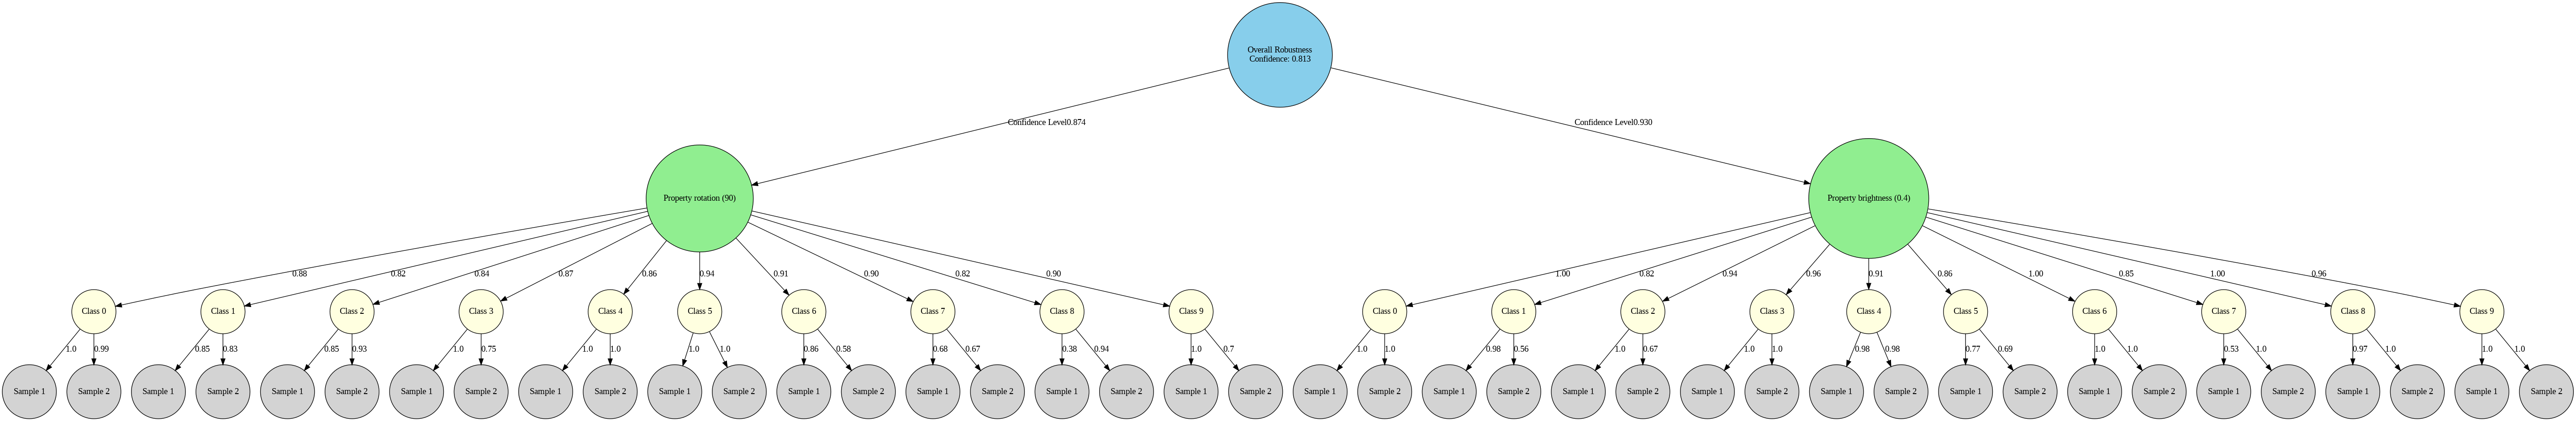

In [204]:
import pydot
from IPython.display import Image
import csv
import numpy as np

# Load confidence scores from CSV
filename = "confidence_scores.csv"
results = {}

with open(filename, mode='r') as file:
    reader = csv.reader(file)
    headers = next(reader)  # Skip headers
    for row in reader:
        property_name, value, class_label, sample_index, confidence_score, predicted_class, correctness = row
        key = f"{property_name}_{value}_class_{class_label}"
        if key not in results:
            results[key] = {'confidence_scores': [], 'predicted_classes': [], 'correctness': []}
        results[key]['confidence_scores'].append(float(confidence_score))
        results[key]['predicted_classes'].append(predicted_class)
        results[key]['correctness'].append(correctness)

# Calculate the mean confidence score for each property
mean_confidence_rotation = np.mean([np.mean(data['confidence_scores']) for key, data in results.items() if 'rotation' in key])
mean_confidence_brightness = np.mean([np.mean(data['confidence_scores']) for key, data in results.items() if 'brightness' in key])

# Calculate the product of the mean confidence scores of the two properties
product_of_means = mean_confidence_rotation * mean_confidence_brightness

# Create the graph
graph = pydot.Dot(graph_type='digraph', rankdir='TB')

# Function to add nodes and edges, with edge labels for confidence
def add_node_with_confidence(parent, child, child_confidence, shape='circle', fillcolor="white", isRoot=False):
    if not isRoot:
        child_label = f"{child}"
        graph.add_node(pydot.Node(child, label=child_label, shape=shape, style="filled", fillcolor=fillcolor))
        # Edge label uses the confidence value
        graph.add_edge(pydot.Edge(parent, child, label=f"{child_confidence:.0%}"))
    else:
        # For root, the confidence is already in the node
        graph.add_edge(pydot.Edge(parent, child, label=""))

# Add properties with their confidence percentages on edges
property_nodes = {}  # Track property nodes to avoid duplicate connections
# Track added class edges
class_edges_added = set()

# Add properties with their confidence percentages on edges
property_nodes = {}  # Track property nodes to avoid duplicate connections

for key, data in results.items():
    property_name, value, _, class_label = key.split('_')
    prop_node_label = f"{property_name} ({value})"

    # Add property node if it doesn't exist
    if property_name not in property_nodes:
        # Calculate the mean confidence score for the current property
        mean_confidence_score = np.mean([np.mean(data['confidence_scores']) for key, data in results.items() if property_name in key])
        prop_node = pydot.Node(prop_node_label, label=f"Property {prop_node_label}", shape='circle', style="filled", fillcolor="lightgreen")
        graph.add_node(prop_node)
        property_nodes[property_name] = prop_node_label
        # Add edge from Overall Robustness to property
        graph.add_edge(pydot.Edge('Overall Robustness', prop_node_label,label=f"Confidence Level{mean_confidence_score:.3f}"))

    # Construct class node label
    class_node_label = f"{class_label} ({property_name})"

    # Add edge from property to class if it doesn't exist
    edge_key = (prop_node_label, class_node_label)
    if edge_key not in class_edges_added:
        # Calculate the mean confidence score for the current class
        mean_confidence_score = np.mean(data['confidence_scores'])
        # Add class node
        class_node = pydot.Node(class_node_label, label=f"Class {class_label}", shape='circle', style="filled", fillcolor="lightyellow")
        graph.add_node(class_node)
        mean_confidence_score = np.mean(data['confidence_scores'])
        # Add edge from property to class with the mean confidence score
        graph.add_edge(pydot.Edge(prop_node_label, class_node_label, label=f"{mean_confidence_score:.2f}"))
        class_edges_added.add(edge_key)

    # # Calculate the mean confidence score for the current class
    # mean_confidence_score = np.mean(data['confidence_scores'])

    # # Add mean confidence score as label on edge connecting property to class
    # graph.add_edge(pydot.Edge(prop_node_label, class_node_label, label=f"{mean_confidence_score:.2f}"))

    # Add samples under each class with their confidences on edges
    num_samples_to_show = 2  # Customize the number of samples to show
    for i in range(min(num_samples_to_show, len(data['confidence_scores']))):
        confidence_score = data['confidence_scores'][i]
        sample_node_label = f"Sample {i+1} ({class_label}, {property_name})"
        sample_node = pydot.Node(sample_node_label, label=f"Sample {i+1}", shape='circle', style="filled", fillcolor="lightgrey")
        graph.add_node(sample_node)
        graph.add_edge(pydot.Edge(class_node_label, sample_node_label, label=f"{confidence_score:.2}"))

# Add the overall robustness score as a node
overall_robustness_label = f"Overall Robustness\nConfidence: {product_of_means:.3f}"
overall_robustness_node = pydot.Node("Overall Robustness", label=overall_robustness_label, shape='circle', style="filled", fillcolor="skyblue")
graph.add_node(overall_robustness_node)

# Generate and save the graph to a file
output_file = 'decision_tree_with_overall_robustness.png'
graph.write_png(output_file)

# Display the graph
Image(output_file)
